# Regional and Local Sea Level Change   
 
```{glue:figure} trend_fig
:scale: 50%
:align: right
```

Since the start of continuous satellite measurements of global sea level in 1993, the absolute mean sea level in the vicinity of the Malakal tide gauge has risen by {glue:text}`delta_cm_altimetry:.2f` cm ({glue:text}`delta_in_altimetry:.2f` in). This compares to a relative value of {glue:text}`delta_cm_tide_gauge:.2f` cm ({glue:text}`delta_in_tide_gauge:.2f` in) measured by the tide gauge over this same time period.   These values correspond to satellite-derived and station-derived rates of {glue:text}`trend_mmyr_altimetry:.2f` mm ({glue:text}`trend_inyr_altimetry:.2f` in) per year and {glue:text}`trend_mmyr_tide_gauge:.2f` mm ({glue:text}`trend_inyr_tide_gauge:.2f` in) per year, respectively. Differences in the rates of absolute (satellite-measured) and relative (tide gauge measured) sea level rise is largely attributable to vertical land motion. The sea level near Palau is rising faster than the global average, with satellite data showing a global mean sea level (GMSL) rise of  4.4 mm (0.17 in) per year ([Willis et al., 2023](https://zenodo.org/records/7702315)).

In this notebook, we'll be creating a [table](SL_magnitude_results), a [map](fig-mag), and a time series [plot](trend_fig) of absolute and regional sea level change at the Malakal, Palau tide gauge station from 1993-2022. Absolute sea level, typically measured by satellite altimetry, refers to the height of the sea surface relative to a reference ellipsoid. Here, we'll use the global ocean gridded L4 Sea Level Anomalies (SLA) available from Copernicus, which is the sea surface height (SSH) minus the mean sea surface (MSS), where the MSS is the temporal mean of SSH over a given period. Relative sea level is measured by a tide gauge, and is the sea level relative to land at that location. Differences between the two measurements can arise from vertical land motion, regional oceanographic conditions like currents, and changes to the gravitational field (affecting the geoid). 

Download Files:
[Map](../output/SL_magnitude_map.png) |
[Time Series Plot](../output/SL_magnitude_timeseries.png) |
[Table](../output/SL_magnitude_results.csv)



## Setup

First, we need to import all the necessary libraries.

In [9]:
# import necessary libraries
import numpy as np
import xarray as xr
import datetime as dt
from pathlib import Path
import pandas as pd
import os
import os.path as op
import sys

# data retrieval libraries
import requests
from urllib.request import urlretrieve #used for downloading files
import json
import copernicusmarine

# data processing libraries
from scipy import stats
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

from myst_nb import glue #used for figure numbering when exporting to LaTeX

sys.path.append("../../../functions")
from data_downloaders import download_oni_index, download_uhslc_data


Next, we'll establish our directory for saving and reading data, and our output files.

In [2]:
data_base_dir =  Path('../../../data')
path_figs = "../../../matrix_cc/figures"
data_dir = Path(data_base_dir,'sea_level')
output_dir = data_base_dir 

# Create the output directory if it does not exist
output_dir.mkdir(exist_ok=True)
data_dir.mkdir(exist_ok=True)

# Also let's just make our figure sizes the same:
plt.rcParams['figure.figsize'] = [10, 4]  # Set a default figure size for the notebook

## Retrieve Data Sources

We are interested in getting tide gauge and alitmetry data for Palau (and its EEZ) for 1993 through 2022.
Let's first establish where the tide gauge is by looking at the tide gauge dataset.

### Retrieve the location of the Malakal, Palau tide gauge

In [3]:
url = 'https://uhslc.soest.hawaii.edu/data/meta.geojson' #<<--- THIS IS A "HIDDEN" URL (Hard to find by clicking around the website.) 
uhslc_id = 7

#parse this url to get lat/lon of Malakal tide gauge
r = requests.get(url)
data = r.json()
for i in range(len(data['features'])):
    if data['features'][i]['properties']['uhslc_id'] == uhslc_id:
        lat = data['features'][i]['geometry']['coordinates'][1]
        lon = data['features'][i]['geometry']['coordinates'][0]
        station = data['features'][i]['properties']['name']
        country = data['features'][i]['properties']['country']
        break

lat,lon,station, country    

(7.33, 134.463, 'Malakal', 'Palau')

Next, let's establish a period of record from 1993-2022.

In [4]:
# establish the time period of interest
start_date = dt.datetime(1993,1,1)
end_date = dt.datetime(2022,12,31)

# also save them as strings, for plotting
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

glue("station",station,display=False)
glue("country",country, display=False)
glue("startDateTime",start_date_str, display=False)
glue("endDateTime",end_date_str, display=False)

### Retrieve the EEZ boundary for Palau

Next we'll define the area we want to look at using the EEZ boundary. This can be obtained from the [Pacific Environmental Data Portal](https://pacific-data.sprep.org). For now it's in the data directory.

In [5]:
# Retrieve the EEZ for Palau
import geopandas as gpd
eezPath = op.join(os.getcwd(), '..', '..','..', 'data/Palau_EEZ/pw_eez_pol_april2022.shp')

# read the shapefile
palau_shp = gpd.read_file(eezPath)
# extract the coordinates of the EEZ
geometry = palau_shp['geometry']

# get the lat and lon of the EEZ
palau_eez = np.array(geometry[0].exterior.coords.xy).T

# get the min and max lat and lon of the EEZ, helpful for obtaining CMEMS data
min_lon = np.min(palau_eez[:,0])
max_lon = np.max(palau_eez[:,0])
min_lat = np.min(palau_eez[:,1])
max_lat = np.max(palau_eez[:,1])

### Retrieve altimetry data 

We are using the global ocean gridded L4 Sea Surface Heights and Derived Variables from Copernicus, available at https://doi.org/10.48670/moi-00148. 

To download a subset of the global altimetry data, run get_CMEMS_data.py from this directory in a terminal with python >= 3.9 + copernicus_marine_client installed OR uncomment out the call to get_CMEMS_data and run it in this notebook. To read more about how to download the data from the Copernicus Marine Toolbox (new as of December 2023), visit https://help.marine.copernicus.eu/en/articles/7949409-copernicus-marine-toolbox-introduction. 

````{margin}
```{note}
You will need a username and password to access the CMEMS (Copernicus Marine Service) data if this is the first time running the client. To register for data access (free), visit https://data.marine.copernicus.eu/register.  
```
````

```{admonition} Large data download!
:class: warning
Getting errors on the code block below? Remember to uncomment "get_CMEMS_data()" to download. Note that if you change nothing in the function, it will download ~600 MB of data, which may take a long time!! You will only need to do this once. The dataset will be stored in the data directory you specify (which should be the same data directory we defined above).
```

In [6]:
def get_CMEMS_data(data_dir):
        
    maxlat = 15
    minlat = 0
    minlon = 125
    maxlon = 140
    
    start_date_str = "1993-01-01T00:00:00"
    end_date_str = "2025-04-30T23:59:59"
    data_dir = data_dir
    
    """
    Retrieves Copernicus Marine data for a specified region and time period.
    
    Args:
        minlon (float): Minimum longitude of the region.
        maxlon (float): Maximum longitude of the region.
        minlat (float): Minimum latitude of the region.
        maxlat (float): Maximum latitude of the region.
        start_date_str (str): Start date of the data in ISO 8601 format.
        end_date_str (str): End date of the data in ISO 8601 format.
        data_dir (str): Directory to save the retrieved data.
    
    Returns:
        str: The filename of the retrieved data.
    """
    copernicusmarine.subset(
        dataset_id="cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.125deg_P1D",
        variables=["adt", "sla"],
        minimum_longitude=minlon,
        maximum_longitude=maxlon,
        minimum_latitude=minlat,
        maximum_latitude=maxlat,
        start_datetime=start_date_str,
        end_datetime=end_date_str,
        output_directory=data_dir,
        output_filename="cmems_L4_SSH_0.125deg_" + start_date_str[0:4] + "_" + end_date_str[0:4] + ".nc"
    )

In [7]:
fname_cmems = 'cmems_L4_SSH_0.125deg_1993_2025.nc'

# check if the file exists, if not, download it
if not os.path.exists(data_dir / fname_cmems):
    print('You will need to download the CMEMS data in a separate script')
    get_CMEMS_data(data_dir) #<<--- COMMENT OUT TO AVOID ACCIDENTAL DATA DOWNLOADS.
else:
    print('CMEMS data already downloaded, good to go!')

# open the CMEMS data
ds = xr.open_dataset(data_dir / fname_cmems)

# slice the data to time 1993-01-01 to 2022-12-31
ds = ds.sel(time=slice(start_date, end_date))
ds


CMEMS data already downloaded, good to go!


<xarray.Dataset> Size: 3GB
Dimensions:    (time: 10957, latitude: 120, longitude: 120)
Coordinates:
  * latitude   (latitude) float32 480B 0.0625 0.1875 0.3125 ... 14.81 14.94
  * longitude  (longitude) float32 480B 125.1 125.2 125.3 ... 139.7 139.8 139.9
  * time       (time) datetime64[ns] 88kB 1993-01-01 1993-01-02 ... 2022-12-31
Data variables:
    adt        (time, latitude, longitude) float64 1GB ...
    sla        (time, latitude, longitude) float64 1GB ...
Attributes:
    references:                http://marine.copernicus.eu
    Conventions:               CF-1.6
    comment:                   Sea Surface Height measured by Altimetry and d...
    title:                     DT merged all satellites Global Ocean Gridded ...
    source:                    Altimetry measurements
    history:                   2024-10-23 12:55:06Z: Creation
    institution:               CLS, CNES
    contact:                   servicedesk.cmems@mercator-ocean.eu
    copernicusmarine_version:  2.0.0a4

### Retrieve Tide Gauge Data

Next we'll retrieve tide gauge data from the UHSLC (University of Hawaii Sea Level Center) fast-delivery dataset {cite:t}``. The fast-delivery data are released within 1-2 months of data collection and are subject only to basic quality control. 

````{margin}
```{note}
What about research quality data (RQD)? 
RQD undergo thorough and time-consuming QC, and are usually released 1-2 years after data is received. 
```
````

The code block below downloads the data file if it doesn't already exist in the specified data directory.
The tide gauge data is then opened using xarray and the station name is extracted.

In [10]:
uhslc_id = 7
# download the hourly data
rsl = download_uhslc_data(data_dir, uhslc_id,'daily')     
station_name = rsl.station_name.values[0] 
rsl 

<xarray.Dataset> Size: 248kB
Dimensions:               (record_id: 1, time: 20620)
Coordinates:
  * time                  (time) datetime64[ns] 165kB 1969-05-19T12:00:00 ......
  * record_id             (record_id) int64 8B 7
Data variables:
    sea_level             (record_id, time) float32 82kB ...
    lat                   (record_id) float32 4B ...
    lon                   (record_id) float32 4B ...
    station_name          (record_id) <U7 28B 'Malakal'
    station_country       (record_id) <U5 20B 'Palau'
    station_country_code  (record_id) float32 4B ...
    uhslc_id              (record_id) int16 2B ...
    gloss_id              (record_id) float32 4B ...
    ssc_id                (record_id) |S4 4B ...
    last_rq_date          (record_id) datetime64[ns] 8B ...
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (daily)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2025-12-22T14:27:15Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

## Process the data

 Now we'll convert tide gauge data into a daily record for the POR in units of meters to match the CMEMS data. 
 
 The next code block:
 - extracts tide gauge data for the period 1993-2022
 - converts it to meters
 - removes any NaN values
 - resamples the data to daily mean
 - and normalizes it relative to the 1993-2012 epoch. 
 
 The resulting data is stored in the variable 'rsl_daily' with units in meters.

In [11]:
# Extract the data for the period of record (POR)
tide_gauge_data_POR = rsl['sea_level'].sel(time=slice(start_date, end_date))

# Convert to meters and drop any NaN values
tide_gauge_data_meters = tide_gauge_data_POR / 1000  # Convert from mm to meters
tide_gauge_data_clean = tide_gauge_data_meters.dropna(dim='time')

# Get the mean relative to the 1993-2012 epoch
epoch_start, epoch_end = '1993-01-01', '2011-12-31'
epoch_daily_avg = tide_gauge_data_clean.sel(time=slice(epoch_start, epoch_end))
epoch_daily_mean = epoch_daily_avg.mean()

# Get the mean relative to the 1983-2001 (NTDE) epoch
epochNTDE_start, epochNTDE_end = '1983-01-01', '2001-12-31'
epoch_daily_avg = tide_gauge_data_clean.sel(time=slice(epochNTDE_start, epochNTDE_end))
epochNTDE_daily_mean = epoch_daily_avg.mean()

# Subtract the epoch NTDE daily mean to put everything in the MSL (NTDE) reference frame
rsl_daily = tide_gauge_data_clean - epochNTDE_daily_mean

# Set the attributes of the rsl_daily data
rsl_daily.attrs = tide_gauge_data_POR.attrs
rsl_daily.attrs['units'] = 'm'


# Remove any singleton dimensions
rsl_daily = rsl_daily.squeeze()

rsl_daily

<xarray.DataArray 'sea_level' (time: 10818)> Size: 43kB
array([-0.11846316, -0.12346315, -0.14646316, ...,  0.0945369 ,
        0.08153689,  0.08553684], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 87kB 1993-01-01T12:00:00 ... 2022-12-30T...
    record_id  int64 8B 7
Attributes:
    long_name:  relative sea level
    units:      m
    source:     in situ tide gauge water level observations
    platform:   station_name, station_country, station_country_code, uhslc_id...

Run a quick check to see if the Ab SL from CMEMS is in fact zeroed about the 1993-2012 epoch. Curse the details.

In [12]:
# Normalize tide gauge data to CMEMS 1993-2012 epoch
epoch_daily_mean_cmems = ds['sla'].sel(
    time=slice(epoch_start, epoch_end)
).sel(
    longitude=lon, latitude=lat, method='nearest'
).mean(dim='time')

formatted_mean = format(epoch_daily_mean_cmems.values, ".2f")

# Print the mean with a note to re-check source data
print(
    f'The mean for the [{epoch_start},{epoch_end}] epoch of the SLA is {formatted_mean} m. '
)

# adjust altimetry anomalies to be relative to MSL (NTDE) reference frame
ds['sla'] = ds['sla'] -epoch_daily_mean_cmems+ epoch_daily_mean - epochNTDE_daily_mean

The mean for the [1993-01-01,2011-12-31] epoch of the SLA is 0.02 m. 


### Clip
Next we'll clip the Altimetry Data Set to the area/grid of interest. For now, we'll focus only on the grid cell nearest to the Malakal tide gauge.

````{margin}
```{note}
There are a few options for tide gauge comparison:
1) Nearest neighbor
2) Highest correlated nearest neighbor
3) Average of n-nearest neighbors, etc

They all end up about the same for the Pacific Islands, so in this example we'll be choosing nearest neighbor.
```
````

In [13]:
sla = ds['sla'].sel(time=slice(start_date, end_date))
time_cmems = pd.to_datetime(sla['time'].values)

# Extract data for the nearest point to the tide gauge location
sla_nearest = sla.sel(longitude=lon, latitude=lat, method='nearest')

sla_nearest_lat = sla_nearest['latitude'].values
sla_nearest_lon = sla_nearest['longitude'].values

# Format lat lon strings to have decimal symbol and N/S and E/W
lat_str = f'{np.abs(sla_nearest_lat):.3f}\u00B0{"N" if sla_nearest_lat > 0 else "S"}'
lon_str = f'{np.abs(sla_nearest_lon):.3f}\u00B0{"E" if sla_nearest_lon > 0 else "W"}'

print(f'The closest altimetry grid point is {lat_str}, {lon_str}')
sla_nearest

The closest altimetry grid point is 7.312°N, 134.438°E


<xarray.DataArray 'sla' (time: 10957)> Size: 88kB
array([-0.04874812, -0.04914812, -0.04984812, ...,  0.11625188,
        0.11475188,  0.11305188])
Coordinates:
    latitude   float32 4B 7.312
    longitude  float32 4B 134.4
  * time       (time) datetime64[ns] 88kB 1993-01-01 1993-01-02 ... 2022-12-31

```{margin}
It should be noted that the coordinates from https://ccar.colorado.edu/altimetry/ for the altimetry product are: Lat: 7.2500°N, Lon: 134.4167°E, using https://podaac.jpl.nasa.gov/dataset/SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL1812 as their data source. This data is gridded at 1/6th of a degree as supposed to 1/8th of a degree in the source we are using.
```

Let's make a map to determine exactly where these points are in space. First we'll define a function to prettify the map, which we'll use for the rest of the notebook.

In [14]:
def add_zebra_frame(ax, lw=2, segment_length=0.5, crs=ccrs.PlateCarree()):
    # Get the current extent of the map
    left, right, bot, top = ax.get_extent(crs=crs)

    # Calculate the nearest 0 or 0.5 degree mark within the current extent
    left_start = left - left % segment_length
    bot_start = bot - bot % segment_length

    # Adjust the start if it does not align with the desired segment start
    if left % segment_length >= segment_length / 2:
        left_start += segment_length
    if bot % segment_length >= segment_length / 2:
        bot_start += segment_length

    # Extend the frame slightly beyond the map extent to ensure full coverage
    right_end = right + (segment_length - right % segment_length)
    top_end = top + (segment_length - top % segment_length)

    # Calculate the number of segments needed for each side
    num_segments_x = int(np.ceil((right_end - left_start) / segment_length))
    num_segments_y = int(np.ceil((top_end - bot_start) / segment_length))

    # Draw horizontal stripes at the top and bottom
    for i in range(num_segments_x):
        color = 'black' if (left_start + i * segment_length) % (2 * segment_length) == 0 else 'white'
        start_x = left_start + i * segment_length
        end_x = start_x + segment_length
        ax.hlines([bot, top], start_x, end_x, colors=color, linewidth=lw, transform=crs)

    # Draw vertical stripes on the left and right
    for j in range(num_segments_y):
        color = 'black' if (bot_start + j * segment_length) % (2 * segment_length) == 0 else 'white'
        start_y = bot_start + j * segment_length
        end_y = start_y + segment_length
        ax.vlines([left, right], start_y, end_y, colors=color, linewidth=lw, transform=crs)


Text(134.4375, 7.362500190734863, 'Nearest Altimetry \n Grid Point')

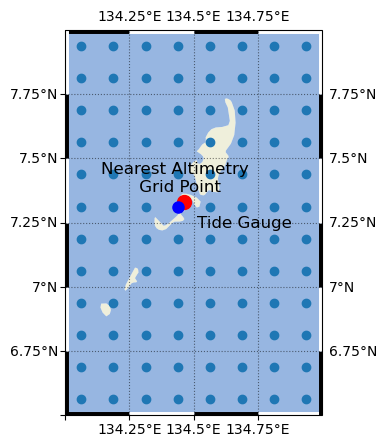

In [15]:
# Set up the map projection
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
crs = ccrs.PlateCarree()

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection': crs})
# Set map limits
xmin, xmax, ymin, ymax = 134, 135, 6.5, 8
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

# add the land and ocean features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)

# Add the tide gauge location
ax.plot(lon, lat, marker='o', color='red', markersize=10, transform=crs)

# Add the altimetry grid point
ax.plot(sla_nearest_lon, sla_nearest_lat, marker='o', 
        color='blue', markersize=8, transform=crs)

# Create 2D arrays of the longitude and latitude values
lon2d, lat2d = np.meshgrid(sla.longitude, sla.latitude)

# plot the latitude and longitude values
ax.scatter(lon2d, lat2d, transform=crs)

# Set custom ticks for the zebra frame
degree_interval = 0.25
ax.set_xticks(np.arange(xmin,xmax,degree_interval), crs=crs)
ax.set_yticks(np.arange(ymin,ymax,degree_interval), crs=crs)
ax.set_xticklabels([]), ax.set_yticklabels([])

# Call the function to add the zebra frame
add_zebra_frame(ax, lw=5, segment_length=0.25, crs=crs)

# add map grid
gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                  alpha=0.5,xlocs=ax.get_xticks(),ylocs=ax.get_yticks())

# Add the tide gauge location with callout text
tide_gauge_label = "Tide Gauge"
ax.text(lon+0.05, lat-0.05, tide_gauge_label, 
        transform=crs, ha='left',va = 'top', fontsize=12)

# Add the altimetry grid point with callout text
altimetry_label = "Nearest Altimetry \n Grid Point"
ax.text(sla_nearest_lon, sla_nearest_lat+0.05, altimetry_label, 
        transform=crs, ha='center', va = 'bottom', fontsize=12)


### Plot the timeseries
Here, we'll plot the time series of the altimetry data at the nearest location to the tide gauge (aka 'sla_nearest'). The units of sla_nearest are in meters, so we'll multiply by 100 to plot in centimeters.

(np.float64(8401.0), np.float64(19357.0))

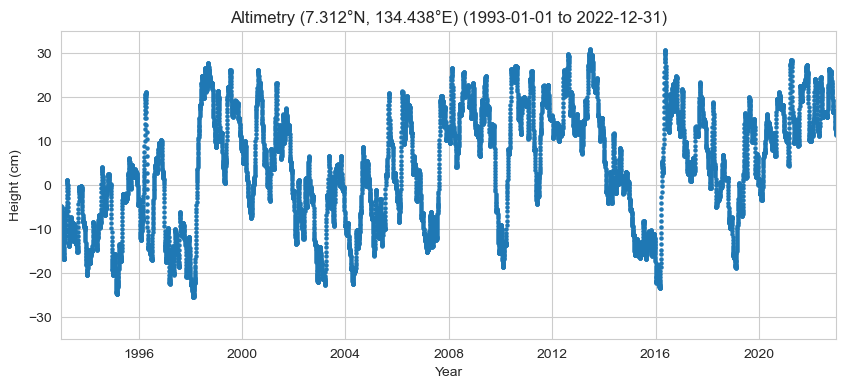

In [16]:
# Set the style of the plot
sns.set_style("whitegrid")

# Set the style of the plot
sns.set_style("whitegrid")

# Create a color palette
palette = sns.color_palette("Paired")

# Create the figure and the axes
fig, ax = plt.subplots()

# Plot the data

# plot altimetry data
ax.scatter(sla_nearest['time'], 100*sla_nearest, label='Altimetry', color=palette[1], alpha=1, s= 5)

# Set the title and labels
ax.set_title(f'Altimetry ({lat_str}, {lon_str}) ({start_date_str} to {end_date_str})')
ax.set_xlabel('Year')
ax.set_ylabel('Height (cm)')

# Set the y limits
ax.set_ylim([-35, 35])

# Set the x limits
ax.set_xlim([start_date, end_date])


### Calculate change
Now we have all of our data sources, we'll calculate the absolute and relative sea level change (magnitude in cm) at this location for the Period of Record (1993-2022).

To do this, we'll first define a function that calculates the sea level change magnitude.

In [17]:
import statsmodels.api as sm
from joblib import Parallel, delayed

def process_trend_with_nan(sea_level_anomaly,n_jobs=1):
    
    # Flatten the data and get a time index
    # first ensure time is the first dimension regardless of other dimensions
    sea_level_anomaly = sea_level_anomaly.transpose('time', ...)
    sla_flat = sea_level_anomaly.values.reshape(sea_level_anomaly.shape[0], -1)
    time_index = pd.to_datetime(sea_level_anomaly.time.values).to_julian_date()

    detrended_flat = np.full_like(sla_flat, fill_value=np.nan)
    trend_rates = np.full(sla_flat.shape[1], fill_value=np.nan)
    p_values = np.full(sla_flat.shape[1], fill_value=np.nan)

    def compute_trend(y,i):
        mask = ~np.isnan(y) 
        if np.any(mask):
            time_masked = time_index[mask]
            y_masked = y[mask]
            slope, intercept, r_value, p_value, _ = stats.linregress(time_masked, y_masked)
            trend = slope * time_index + intercept
            return slope, trend, p_value
        return np.nan, np.nan
    
    #run in parallel
    results = Parallel(n_jobs=n_jobs)(delayed(compute_trend)(sla_flat[:,i],i) for i in range(sla_flat.shape[1]))
    trend_rates, p_values = zip(*results)

    #convert to numpy arrays
    trend_rates = np.array(trend_rates)
    p_values = np.array(p_values)

    # compute magnitude of trend
    sea_level_trend = np.outer(time_index, trend_rates)
    trend_mag = sea_level_trend[-1] - sea_level_trend[0]

    # compute time magnitude
    times = pd.to_datetime(sea_level_anomaly['time'].values)
    time_mag = (times[-1] - times[0]).days/365.25 # in years

    # compute trend rate
    trend_rate = trend_mag / time_mag

    trend_mag= xr.DataArray(trend_mag, coords=[("latitude", sla.latitude), ("longitude", sla.longitude)])
    trend_rate= xr.DataArray(trend_rate, coords=[("latitude", sla.latitude), ("longitude", sla.longitude)])
    sea_level_trend = xr.DataArray(sea_level_trend, coords=[("time", sea_level_anomaly.time), ("latitude", sla.latitude), ("longitude", sla.longitude)])

    return trend_mag, sea_level_trend, trend_rate, np.nanmean(p_values)


    # # Loop over each grid point
    # for i in range(sla_flat.shape[1]):
    #     # Get the time series for this grid point
    #     y = sla_flat[:,i]
    #     mask = ~np.isnan(y)

    #     detrended_flat = np.full_like(sla_flat, fill_value=np.nan)
    #     trend_rates = []
    #     p_values = []

    #     if np.any(mask):
    #         time_masked = time_index[mask]
    #         y_masked = y[mask]

    #         X = sm.add_constant(time_masked)
    #         model = sm.OLS(y_masked, X).fit(cov_type='nonrobust')

    #         trend = model.params[1] * time_index + model.params[0]
    #         detrended_flat[:, i] = y - trend

    #         trend_rates.append(model.params[1])  # Extract the slope
    #         p_values.append(model.pvalues[1])  # Corrected p-value

    #         # slope, intercept, r_value, p_value, _ = stats.linregress(time_masked, y_masked)
    #         # trend = slope * time_index + intercept

    #         detrended_flat[:,i] = y - trend

    # detrended = detrended_flat.reshape(sea_level_anomaly.shape)

    # # Calculate trend magnitude
    # sea_level_trend = sea_level_anomaly - detrended
    # trend_mag = sea_level_trend[-1] - sea_level_trend[0]

    # times = pd.to_datetime(sea_level_anomaly['time'].values)
    # time_mag = (times[-1] - times[0]).days/365.25 # in years

    # trend_rate = trend_mag / time_mag


    # return trend_mag, sea_level_trend, trend_rate , np.mean(p_values) # corrected p-value

In [18]:
def process_trend_with_nan(sea_level_anomaly):
    # Flatten the data and get a time index
    # first ensure time is the first dimension regardless of other dimensions
    sea_level_anomaly = sea_level_anomaly.transpose('time', ...)
    sla_flat = sea_level_anomaly.values.reshape(sea_level_anomaly.shape[0], -1)
    time_index = pd.to_datetime(sea_level_anomaly.time.values).to_julian_date()

    detrended_flat = np.full_like(sla_flat, fill_value=np.nan)
    detrended_flat_err = np.full_like(sla_flat, fill_value=np.nan)
    trend_rates = np.full(sla_flat.shape[1], np.nan)
    trend_errors = np.full(sla_flat.shape[1], np.nan)
    p_values = np.full(sla_flat.shape[1], np.nan)



    # Loop over each grid point
    for i in range(sla_flat.shape[1]):
        # Get the time series for this grid point
        y = sla_flat[:,i]
        mask = ~np.isnan(y)

        if np.any(mask):
            time_masked = time_index[mask]
            y_masked = y[mask]

            slope, intercept, _, p_value, std_error = stats.linregress(time_masked, y_masked)
            trend = slope * time_index + intercept

            detrended_flat[:,i] = y - trend
            trend_rates[i] = slope
            trend_errors[i] = std_error
            p_values[i] = p_value

    detrended = detrended_flat.reshape(sea_level_anomaly.shape)
    trend_errors_reshaped = trend_errors.reshape(sea_level_anomaly.shape[1:])

    # Calculate trend magnitude
    sea_level_trend = sea_level_anomaly - detrended
    trend_mag = sea_level_trend[-1] - sea_level_trend[0]

    times = pd.to_datetime(sea_level_anomaly['time'].values)
    time_mag = (times[-1] - times[0]).days/365.25 # in years

    trend_rate = trend_mag / time_mag
    trend_err = trend_errors_reshaped / time_mag

    return trend_mag, sea_level_trend, trend_rate, np.nanmean(p_value) , np.nanmean(trend_err)

Now we'll run that function for every grid point in our dataset, and make special variables for our proxy tide gauge location.

In [19]:
trend_mag_cmems, trend_line_cmems, trend_rate_cmems, p_value_cmems, trend_err_cmems = process_trend_with_nan(sla)

trend_mag_asl, trend_line_asl, trend_rate_asl, p_value_asl,trend_err_asl = process_trend_with_nan(sla_nearest)

Calculate the weighted mean for the region of interest. (Probably not necessary for this application ???)


In [20]:
# calculate the area weights as cosine of latitude
# For a rectangular grid, this is equivalent to multiplying by the grid cell area
weights = np.cos(np.deg2rad(sla.latitude))
weights.name = "weights"

# apply weights to the trend data
trend_mag_weighted = trend_mag_cmems.weighted(weights)

# calculate the regional mean
trend_mag_regional = trend_mag_weighted.mean(dim=('latitude', 'longitude'))

# prepare the output string
output = (
    'The regional magnitude of sea level change is {:.2f} cm for the time '
    'period bounded by {} and {}.'
).format(100*trend_mag_regional.values, start_date_str, end_date_str)

print(output)

The regional magnitude of sea level change is 15.33 cm for the time period bounded by 1993-01-01 and 2022-12-31.


### Plot a map
Plot the Results (in a map that includes the EEZ) – MAP

In [21]:
def plot_map(vmin, vmax, xlims, ylims):
    """
    Plot a map of the magnitude of sea level change.

    Parameters:
    vmin (float): Minimum value for the color scale.
    vmax (float): Maximum value for the color scale.
    xlims (tuple): Tuple of min and max values for the x-axis limits.
    ylims (tuple): Tuple of min and max values for the y-axis limits.

    Returns:
    fig (matplotlib.figure.Figure): The matplotlib figure object.
    ax (matplotlib.axes._subplots.AxesSubplot): The matplotlib axes object.
    crs (cartopy.crs.Projection): The cartopy projection object.
    cmap (matplotlib.colors.Colormap): The colormap used for the plot.
    """
    crs = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': crs})
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

    palette = sns.color_palette("mako_r", as_cmap=True)
    cmap = palette

    ax.coastlines()
    ax.add_feature(cfeature.LAND, color='lightgrey')

    return fig, ax, crs, cmap

def plot_zebra_frame(ax, lw=5, segment_length=2, crs=ccrs.PlateCarree()):
    """
    Plot a zebra frame on the given axes.

    Parameters:
    - ax: The axes object on which to plot the zebra frame.
    - lw: The line width of the zebra frame. Default is 5.
    - segment_length: The length of each segment in the zebra frame. Default is 2.
    - crs: The coordinate reference system of the axes. Default is ccrs.PlateCarree().
    """
    # Call the function to add the zebra frame
    add_zebra_frame(ax=ax, lw=lw, segment_length=segment_length, crs=crs)
    # add map grid
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                      alpha=0.5,xlocs=ax.get_xticks(),ylocs=ax.get_yticks())
    #remove labels from top and right axes
    gl.top_labels = False
    gl.right_labels = False

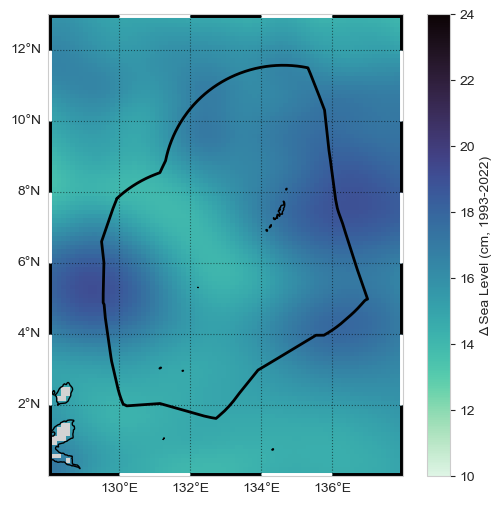

In [22]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
xlims = [128, 138]
ylims = [0, 13]
vmin, vmax = 10, 24


fig, ax, crs,cmap = plot_map(vmin,vmax,xlims,ylims)

# plot the trend*100 for centimeters
trend_mag_cmems_cm = trend_mag_cmems * 100

# plot a map of the magnitude of SL change in centimeters
trend_mag_cmems_cm.plot(ax=ax, transform=crs,
                         vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=True, 
                         cbar_kwargs={'label': 'Δ Sea Level (cm, 1993-2022)'},
)

# add the EEZ
ax.plot(palau_eez[:, 0], palau_eez[:, 1], transform=crs, color='black', linewidth=2)


# Call the function to add the zebra frame
plot_zebra_frame(ax, lw=5, segment_length=2, crs=crs)
plt.savefig(op.join(path_figs, 'F10_SeaLevel_map.png'), dpi=300, bbox_inches='tight')



(ASLtimeseries)=
### Plot time series
Now we'll plot a time series that includes a trend line, the Absolute Sea Level Change (magnitude in cm) within area/s in proximity to the Tide Station/s


Text(0.95, 0.05, 'Δ Sea Level: 17.34 cm, Trend: 0.58 cm/year')

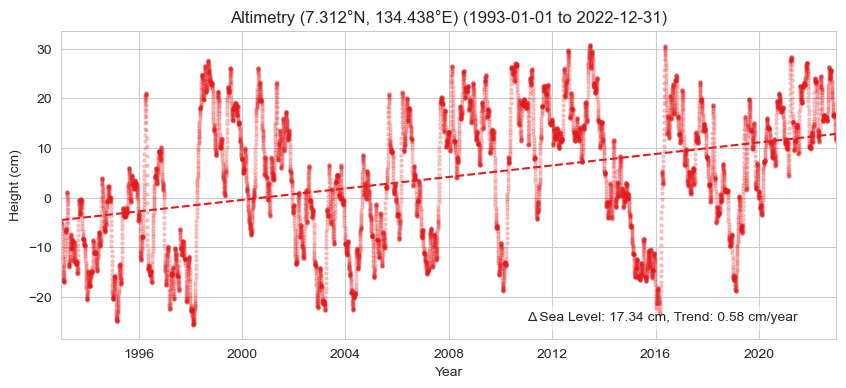

In [23]:
# Set the style of the plot
sns.set_style("whitegrid")

# Create a color palette
palette = sns.color_palette("Set1")

# Plot the timeseries
# Create the figure and the axes
fig, ax = plt.subplots()

# plot altimetry data
ax.scatter(sla_nearest['time'], 100*sla_nearest, label='Altimetry', 
           color=palette[0], alpha=0.2, s=5)
ax.plot(time_cmems, 100*trend_line_asl, label='Altimetry Trend', 
        color=palette[0], linestyle='--')

# Set the title and labels
title = f'Altimetry ({lat_str}, {lon_str}) ({start_date_str} to {end_date_str})'
ax.set_title(title)
ax.set_xlabel('Year')
ax.set_ylabel('Height (cm)')

# Set the x limits
ax.set_xlim([start_date, end_date])

# Add a legend
trendmag_str = (f'Δ Sea Level: {100*trend_mag_asl:.2f} cm, '
                f'Trend: {100*trend_rate_asl:.2f} cm/year')

# Add text in a white box to bottom right of plot
ax.text(0.95, 0.05, trendmag_str, transform=ax.transAxes, 
        verticalalignment='bottom', horizontalalignment='right', 
        bbox=dict(facecolor='white', alpha=0.5))

## Retrieve the Tide Station Data 



### Plot the hourly time series
For a quick glance at the data

In [24]:
rsl_daily

<xarray.DataArray 'sea_level' (time: 10818)> Size: 43kB
array([-0.11846316, -0.12346315, -0.14646316, ...,  0.0945369 ,
        0.08153689,  0.08553684], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 87kB 1993-01-01T12:00:00 ... 2022-12-30T...
    record_id  int64 8B 7
Attributes:
    long_name:  relative sea level
    units:      m
    source:     in situ tide gauge water level observations
    platform:   station_name, station_country, station_country_code, uhslc_id...

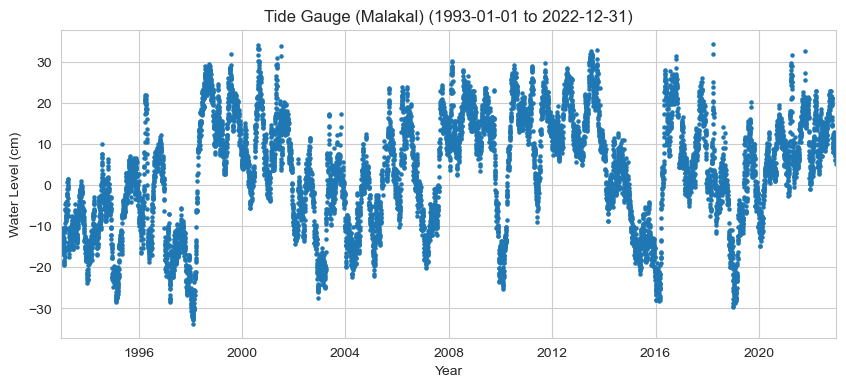

In [25]:
# Set the style of the plot
sns.set_style("whitegrid")

# Set the style of the plot
sns.set_style("whitegrid")

# Create a color palette
palette = sns.color_palette("Paired")

# Create the figure and the axes
fig, ax = plt.subplots()

# Plot the data

# plot tide gauge data
ax.scatter(rsl_daily['time'],100*rsl_daily, label='RSL', 
           color=palette[1], alpha=1, s= 5)

# Set the title, labels, and limits
ax.set(
    title=f'Tide Gauge ({station_name}) ({start_date_str} to {end_date_str})',
    xlabel='Year',
    ylabel='Water Level (cm)',
    # ylim=[-50, 50],
    xlim=[start_date, end_date]
);




### Calculate rate and magnitude of change
Calculate values for both the Trend (rate of change) and Magnitude of Change

In [26]:
# calculate the rate of change for the tide gauge
trend_mag_rsl, trend_line_rsl, trend_rate_rsl, p_value_rsl, trend_err_rsl = process_trend_with_nan(rsl_daily.sel(time=slice(start_date, end_date)))

print(f'The trend magnitude for the tide gauge is {100*trend_mag_rsl:.2f} cm.')
print(f'The trend rate for the tide gauge is {100*trend_rate_rsl:.2f} cm/year.')

The trend magnitude for the tide gauge is 12.17 cm.
The trend rate for the tide gauge is 0.41 cm/year.


(RSLtimeseries)=
### Plot time series
Now we'll combine our daily relative sea level time series, the monthly mean, and a trend line into the same plot. We will label it with the Relative Sea Level Sea Level Change (magnitude in cm) and rate of change (cm/yr) at the Tide Station. The "zero" line is referenced to the [1993,2012] period, following the altimetry. 


Text(0.95, 0.05, 'Δ Sea Level: 12.17 cm, Trend: 0.41 cm/year')

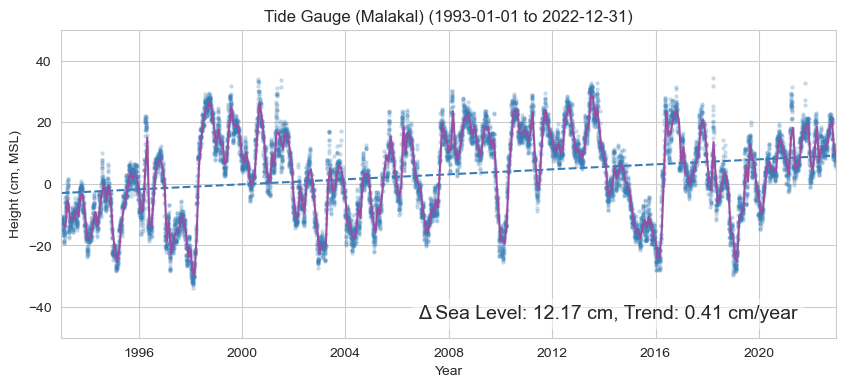

In [27]:
# make an rsl monthly mean for plotting
rsl_monthly = rsl_daily.resample(time='1ME').mean().squeeze()

# Set the style of the plot
sns.set_style("whitegrid")

# Create a color palette
palette = sns.color_palette("Set1")

# Plot the timeseries
# Create the figure and the axes
fig, ax = plt.subplots()
# plot altimetry data
ax.scatter(rsl_daily['time'], 100*rsl_daily, 
           label='Tide Gauge', color=palette[1], alpha=0.2, s= 5)
ax.plot(rsl_daily['time'], 100*trend_line_rsl, 
        label='Tide Gauge Trend', color=palette[1], linestyle='--')
# plot the monthly mean sea level
ax.plot(rsl_monthly['time'], 100*rsl_monthly, 
        label='Tide Gauge', color=palette[3])


# Set the title and labels
ax.set_title(f'Tide Gauge ({station_name}) ({start_date_str} to {end_date_str})')
ax.set_xlabel('Year')
ax.set_ylabel('Height (cm, MSL)')

# Set the y limits
ax.set_ylim([-50, 50])

# Set the x limits
ax.set_xlim([start_date, end_date])

# Add a legend
trendmag_str = f'Δ Sea Level: {100*trend_mag_rsl:.2f} cm, Trend: {100*trend_rate_rsl:.2f} cm/year'
# Add text in a white box to bottom right of plot
ax.text(0.95, 0.05, trendmag_str, transform=ax.transAxes, 
        fontsize=14, verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.5))


## Combining both sources

### Create a Table 
That compares the results of the [absolute](ASLtimeseries)  and [relative](RSLtimeseries) time series.

In [28]:

# Constants
DATA_SOURCE_ALTIMETRY = 'CMEMS SSH L4 0.125 deg (SLA)'
DATA_SOURCE_TIDE_GAUGE = 'UHSLC RQDS'
TIME_PERIOD = f'{start_date_str} to {end_date_str}'

# Calculated values 
trend_mmyr_altimetry = 1000 * trend_rate_asl.values
trend_mmyr_tide_gauge = 1000 * trend_rate_rsl.values
delta_sea_level_altimetry = 100 * trend_mag_asl.values
delta_sea_level_tide_gauge = 100 * trend_mag_rsl.values


# Create DataFrame
SL_magnitude_results = pd.DataFrame({
    'Trend (mm/yr)': [trend_mmyr_altimetry, trend_mmyr_tide_gauge],
    'Trend (in/yr)': [trend_mmyr_altimetry * 0.0393701, trend_mmyr_tide_gauge * 0.0393701],
    'Δ Sea Level (cm)': [delta_sea_level_altimetry, delta_sea_level_tide_gauge],
    'Δ Sea Level (in)': [delta_sea_level_altimetry * 0.393701, delta_sea_level_tide_gauge * 0.393701],
    'Latitude': [sla_nearest_lat, rsl['lat'].values[0]],
    'Longitude': [sla_nearest_lon, rsl['lon'].values[0]],
    'Time_Period': [TIME_PERIOD, TIME_PERIOD],
    'Data_Source': [DATA_SOURCE_ALTIMETRY, DATA_SOURCE_TIDE_GAUGE],
}, index=['Altimetry', 'Tide Gauge'])

# Save to CSV
output_file_path = output_dir / 'SL_magnitude_results.csv'

# Use the path for operations, e.g., saving a DataFrame
SL_magnitude_results.to_csv(output_file_path)

# glue trend_rates to the notebook
# glue("trend_rate_rsl", trend_rate_rsl, display=False)
# glue("trend_rate_asl", trend_rate_asl, display=False)




SL_magnitude_results



,Trend (mm/yr),Trend (in/yr),Δ Sea Level (cm),Δ Sea Level (in),Latitude,Longitude,Time_Period,Data_Source
Altimetry,5.779614,0.227544,17.336469,6.825385,7.3125,134.4375,1993-01-01 to 2022-12-31,CMEMS SSH L4 0.125 deg (SLA)
Tide Gauge,4.055964,0.159684,12.165114,4.789418,7.33,134.462997,1993-01-01 to 2022-12-31,UHSLC RQDS


The cell below will save all these variables for printing:

In [29]:
# glue all table values to the notebook (trend rates etc)

glue("trend_mmyr_altimetry", trend_mmyr_altimetry, display=False)
glue("trend_inyr_altimetry", trend_mmyr_altimetry * 0.0393701, display=False)
glue("trend_mmyr_tide_gauge", trend_mmyr_tide_gauge, display=False)
glue("trend_inyr_tide_gauge", trend_mmyr_tide_gauge * 0.0393701, display=False)
glue("delta_cm_altimetry", delta_sea_level_altimetry, display=False)
glue("delta_in_altimetry", delta_sea_level_altimetry * 0.393701, display=False)
glue("delta_cm_tide_gauge", delta_sea_level_tide_gauge, display=False)
glue("delta_in_tide_gauge", delta_sea_level_tide_gauge * 0.393701, display=False)

### Create a Map 
Now we'll combine a both the tide gauge and altimetry sources into a map that includes the absolute change with the addition of an icon depicting the magnitude of relative change at the tide station.


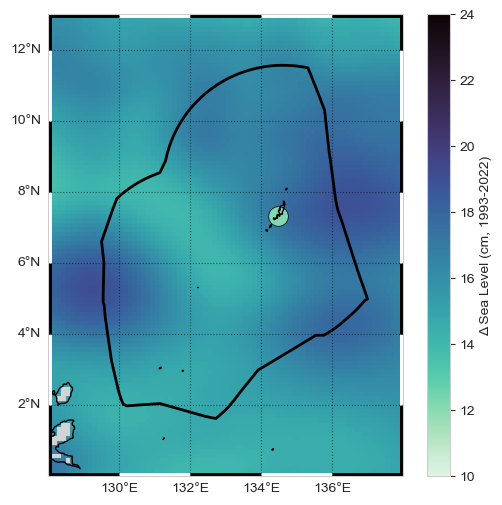

In [30]:
warnings.filterwarnings('ignore', category=RuntimeWarning)
fig, ax, crs,cmap = plot_map(vmin,vmax,xlims,ylims)

# plot the trend*100 for centimeters
trend_mag_cmems_cm = trend_mag_cmems * 100

# plot a map of the magnitude of SL change in centimeters
trend_mag_cmems_cm.plot(ax=ax, transform=crs,
                         vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=True, 
                         cbar_kwargs={'label': 'Δ Sea Level (cm, 1993-2022)'},
)

# add the EEZ
ax.plot(palau_eez[:, 0], palau_eez[:, 1], transform=crs, color='black', linewidth=2)
# add the tide gauge location with black outlined dot, colored by the sea level value
ax.scatter(rsl['lon'], rsl['lat'], transform=crs, s=200, 
           c=100*trend_mag_rsl, vmin=vmin, vmax=vmax, cmap=cmap,
           linewidth=0.5, edgecolor='black')

plot_zebra_frame(ax, lw=5, segment_length=2, crs=crs)

glue("mag_fig", fig, display=False)

# save the figure
output_file_path = output_dir / 'SL_magnitude_map.png'
fig.savefig(output_file_path, dpi=300, bbox_inches='tight')

```{glue:figure} mag_fig
:name: "fig-mag"

Map of absolute and relative sea level change from the altimetry and tide gauge record near {glue:text}`station`, {glue:text}`country` station from {glue:text}`startDateTime` to {glue:text}`endDateTime`.
```


 ### Create a Time series plot 
 Finally we will combine both tide gauge and altimetry sources into a time series plot that includes both [Absolute](ASLtimeseries)  and [Relative](RSLtimeseries) Time Series.

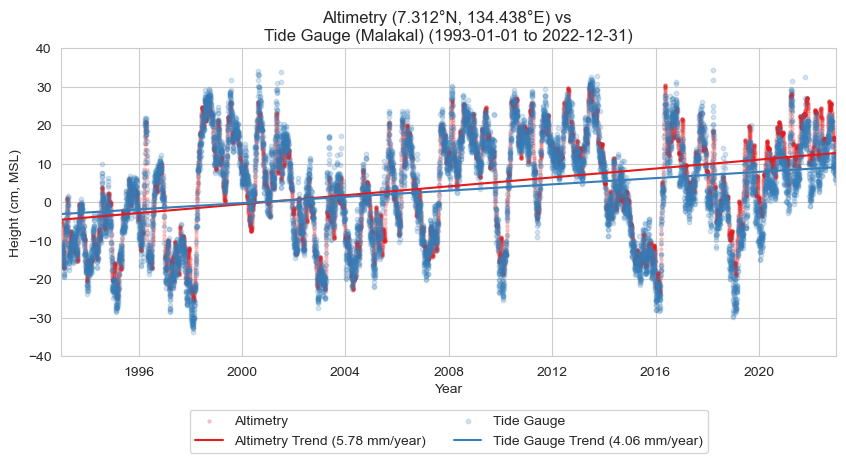

In [31]:
# Set the style of the plot
sns.set_style("whitegrid")

# Create a color palette
palette = sns.color_palette("Set1")

# Create the figure and the axes
fig, ax = plt.subplots()

# plot altimetry data
labelSat = f'Altimetry Trend ({1000*trend_rate_asl:.2f} mm/year)'
ax.scatter(sla_nearest['time'], 100*sla_nearest, 
           label='Altimetry', color=palette[0], alpha=0.2, s=5)
ax.plot(sla_nearest['time'], 100*trend_line_asl, 
        label=labelSat, color=palette[0], linestyle='-')

# plot tide gauge data
labelTG = f'Tide Gauge Trend ({1000*trend_rate_rsl:.2f} mm/year)'
ax.scatter(rsl_daily['time'], 100*rsl_daily, 
           label='Tide Gauge', color=palette[1], alpha=0.2, s=10)
ax.plot(rsl_daily['time'], 100*trend_line_rsl, 
        label=labelTG, color=palette[1], linestyle='-')

# Set the title and labels
title = (
    f'Altimetry ({lat_str}, {lon_str}) vs \n'
    f'Tide Gauge ({station_name}) ({start_date_str} to {end_date_str})'
)
ax.set_title(title)
ax.set_xlabel('Year')
ax.set_ylabel('Height (cm, MSL)')

# Set the y and x limits
ax.set_ylim([-40, 40])
ax.set_xlim([start_date, end_date])

# Add a legend below the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

glue("trend_fig", fig, display=False)

# save the figure
output_file_path = output_dir / 'SL_magnitude_timeseries.png'
fig.savefig(output_file_path, dpi=300, bbox_inches='tight')

plt.savefig(op.join(path_figs, 'F10_SeaLevel_trends.png'), dpi=300, bbox_inches='tight')


```{glue:figure} trend_fig
:name: "trend_fig"

Absolute sea level trend (red) from altimetry, and relative sea level trend (blue) from the tide gauge record at the {glue:text}`station`, {glue:text}`country` station from {glue:text}`startDateTime` to {glue:text}`endDateTime`. Note also that the trends should go through 0 at the same location, but we are using different PORs for both. I need to fix this!!
```

In [32]:
rsl

<xarray.Dataset> Size: 248kB
Dimensions:               (record_id: 1, time: 20620)
Coordinates:
  * time                  (time) datetime64[ns] 165kB 1969-05-19T12:00:00 ......
  * record_id             (record_id) int64 8B 7
Data variables:
    sea_level             (record_id, time) float32 82kB ...
    lat                   (record_id) float32 4B 7.33
    lon                   (record_id) float32 4B 134.5
    station_name          (record_id) <U7 28B 'Malakal'
    station_country       (record_id) <U5 20B 'Palau'
    station_country_code  (record_id) float32 4B ...
    uhslc_id              (record_id) int16 2B ...
    gloss_id              (record_id) float32 4B ...
    ssc_id                (record_id) |S4 4B ...
    last_rq_date          (record_id) datetime64[ns] 8B ...
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (daily)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2025-12-22T14:27:15Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

## ENSO Effects on Sea Level

Next we'll look at the variation of sea level with El Niño and La Niña.

In [33]:
# add nino
p_data = 'https://psl.noaa.gov/data/correlation/oni.data'
oni = download_oni_index(p_data)

In [34]:
# Remove the trend from the tide gauge timeseries
detrended_rsl = rsl_daily - trend_line_rsl

# estimate the seasonal cycle (detrended_rsl is xarray)
seasonal_cycle = detrended_rsl.groupby('time.dayofyear').mean('time')

# Remove the seasonal cycle from the detrended tide gauge timeseries
deseasoned_rsl = detrended_rsl.groupby('time.dayofyear') - seasonal_cycle

# Resample the ONI index to daily frequency and align with the tide gauge timeseries
oni_daily = oni.resample('D').interpolate(method='linear')
oni_daily = oni_daily.reindex(deseasoned_rsl['time'], method='nearest')

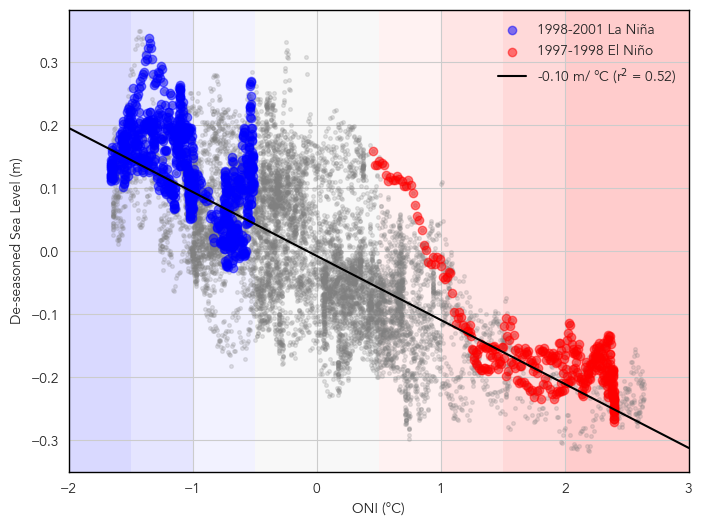

In [35]:
# scatter plot of oni daily and detrended sea level
# Scatter plot of ONI daily and detrended sea level
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(oni_daily, deseasoned_rsl, color='gray', alpha=0.2, s=7)
ax.set_xlabel('ONI (°C)')
ax.set_ylabel('De-seasoned Sea Level (m)')

# Emphasize the 1997-1998 and 2015-2016 El Niño events using pandas indexing
nina_1998 = deseasoned_rsl.sel(time=slice('1998-08-01', '2001-01-30'))
nino_1997 = deseasoned_rsl.sel(time=slice('1997-06-01', '1998-04-30'))

# Plot as dashed lines
ax.scatter(oni_daily.loc['1998-08-01':'2001-01-30'], nina_1998, color='blue', label='1998-2001 La Niña',alpha=0.5)
ax.scatter(oni_daily.loc['1997-06-01':'1998-04-30'], nino_1997, color='red', label='1997-1998 El Niño',alpha=0.5)

# draw a correlation line
# Keep only valid (non-NaN) indices
deseasoned_rsl_series = deseasoned_rsl.to_series()
valid_mask = ~deseasoned_rsl_series.isna()
oni_valid = oni_daily.squeeze().loc[valid_mask]
deseasoned_valid = deseasoned_rsl_series.loc[valid_mask]

slope, intercept, r_value, p_value, std_err = stats.linregress(oni_valid, deseasoned_valid, )
x = np.linspace(-2,3,100)
y = slope * x + intercept
ax.plot(x, y, color='black', linestyle='-', label=f'{slope:.2f} m/ °C (r$^2$ = {r_value**2:.2f})')

ax.set_xlim(-2,3)
ax.legend(frameon=False)
# Add shading for different ONI ranges


ax.axvspan(-2, -1.5, color='blue', alpha=0.15, linewidth=0, zorder=0)
ax.axvspan(-1.5, -1, color='blue', alpha=0.10, linewidth=0, zorder=0)
ax.axvspan(-1, -0.5, color='blue', alpha=0.05, linewidth=0, zorder=0)
ax.axvspan(-0.5, 0.5, color='gray', alpha=0.05, linewidth=0, zorder=0)
ax.axvspan(0.5, 1, color='red', alpha=0.05, linewidth=0, zorder=0)
ax.axvspan(1, 1.5, color='red', alpha=0.10, linewidth=0, zorder=0)
ax.axvspan(1.5, 2, color='red', alpha=0.15, linewidth=0, zorder=0)
ax.axvspan(2, 3, color='red', alpha=0.20, linewidth=0, zorder=0)


# spines should be black not gray

for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

# set all text to avenir
for text in ax.texts:
    text.set_fontname('Avenir')

# set all labels to avenir
for label in ax.get_xticklabels() + ax.get_yticklabels() + ax.get_legend().get_texts() :
    label.set_fontname('Avenir')

ax.xaxis.label.set_fontname('Avenir')
ax.yaxis.label.set_fontname('Avenir')

plt.show()

# save the figure
output_file_path = output_dir / 'SL_ONI_scatter.png'
fig.savefig(output_file_path, dpi=300, bbox_inches='tight')


In [36]:
# Create a DataFrame to summarize the results
summary_data = {
    'Description': ['Slope of Correlation Line', 
                    'El Niño 1997-1998 Min Sea Level', 
                    'El Niño 1997-1998 Median Sea Level',
                    'La Niña 1998-2000 Max Sea Level', 
                    'La Niña 1998-2000 Median Sea Level',
                    'Correlation Coefficient (r)', 
                    'p-value'],
    'Value': [slope, 
              100*nino_1997.min().values,
              100*nino_1997.median().values, 
              100*nina_1998.max().values, 
              100*nina_1998.median().values,
              r_value, 
              p_value],
    'units': ['m/°C', 'cm', 'cm','cm', 'cm', '', '']
}

summary_df = pd.DataFrame(summary_data)

summary_df.attrs['description'] = "Correlation of Sea Level at Malakal with ONI 1983-2024."
summary_df.attrs['source'] = "NOAA / University of Hawaii Sea Level Center"
summary_df.attrs['notes'] = "Sea level data has been deseasoned and detrended."

# Display the summary table with attributes

# Function to format values with units
def format_with_units(value, unit):
    if pd.isna(value):  # Handle NaNs
        return "N/A"
    if unit:  # Add unit only if it's not an empty string
        return f"{value:.2f} {unit}"
    return f"{value:.2f}"  # No unit, just the value

# Apply formatting
summary_df['Formatted'] = summary_df.apply(lambda row: format_with_units(row['Value'], row['units']), axis=1)

# Keep only needed columns (remove 'Value' and 'units' separately)
formatted_df = summary_df[['Description', 'Formatted']].rename(columns={'Formatted': 'Value'})

# Remove index for clean display
formatted_df = formatted_df.reset_index(drop=True)



footer_text = f"Source: {summary_df.attrs['source']}"
notes_text = f"Notes: {summary_df.attrs['notes']}"
footer_df = pd.DataFrame({'Description': [footer_text, notes_text], 
                          'Value': ['','']})

# Combine summary table with footer
summary_table = pd.concat([formatted_df, footer_df], ignore_index=True)  # Removes index completely

# Apply styling
styled_df = summary_table.style.set_caption(
    summary_df.attrs['description']
).set_table_styles([
    {
        'selector': 'caption',
        'props': [('color', 'black'), ('font-size', '16px'), ('font-weight', 'bold')]
    },
    {
        'selector': 'tbody tr:last-child td, tbody tr:nth-last-child(2) td',  # Targets last two rows (footer)
        'props': [('font-style', 'italic'), ('font-align', 'center')]
    }
])



# Save the summary table to a CSV file
summary_file_path = output_dir / 'ENSO_SL_influence_summary.csv'
summary_table.to_csv(summary_file_path, index=False)


styled_df

,Description,Value
0,Slope of Correlation Line,-0.10 m/°C
1,El Niño 1997-1998 Min Sea Level,-27.16 cm
2,El Niño 1997-1998 Median Sea Level,-17.61 cm
3,La Niña 1998-2000 Max Sea Level,33.81 cm
4,La Niña 1998-2000 Median Sea Level,13.63 cm
5,Correlation Coefficient (r),-0.72
6,p-value,0.00
7,Source: NOAA / University of Hawaii Sea Level Center,
8,Notes: Sea level data has been deseasoned and detrended.,
